<a href="https://colab.research.google.com/github/Tongxi-Hu/deep-learning/blob/main/d2l/7_2_modern_convolutional_neural_network_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7-2 modern convolutional neural network II

### 7-2-1 parallele concatenations (googlenet)

In [ ]:
!pip3 install d2l
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [5]:
class Inception(nn.Module):
    # c's standing for the channels number in different tunnel
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs) -> None:
        super(Inception,self).__init__(**kwargs)
        self.p1_1=nn.Conv2d(in_channels,c1,kernel_size=1)
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        self.p3_1=nn.Conv2d(in_channels,c3[0],kernel_size=1)
        self.p3_2=nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_channels,c4,kernel_size=1)
    
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(F.relu(self.p4_1(x))))
        return torch.cat((p1,p2,p3,p4),dim=1)


In [6]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [7]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 7-2-2 batch normalization

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    if not torch.is_grad_enabled():
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape)==2:
            mean = X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else:
            mean=X.mean(dim=(0,2,3),keepdim=True)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        X_hat=(X-mean)/torch.sqrt(var+eps)
        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta
    return Y,moving_mean.data,moving_var.data

In [10]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [11]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.273, train acc 0.899, test acc 0.881
10803.4 examples/sec on cuda:0


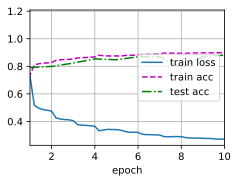

In [12]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [13]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([0.5869, 4.1767, 2.9326, 2.6210, 2.4388, 2.9554], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 1.2162,  2.2247, -1.9779, -0.8244, -1.9595, -3.2159], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [14]:
#concise implementaion
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.266, train acc 0.902, test acc 0.875
19985.8 examples/sec on cuda:0


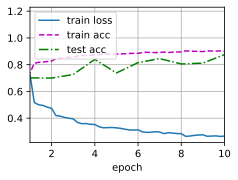

In [15]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 7-2-3 residual networks (resnet)

In [18]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)
        self.conv2=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)
        else:
            self.conv3=None
        self.bn1=nn.BatchNorm2d(num_channels)
        self.bn2=nn.BatchNorm2d(num_channels)
    def forward(self,X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        Y+=X
        return F.relu(Y)

In [19]:
blk=Residual(3,3)
X=torch.randn(4,3,6,6)
Y=blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [20]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [31]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [30]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [32]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [33]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [34]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.012, train acc 0.997, test acc 0.923
633.7 examples/sec on cuda:0


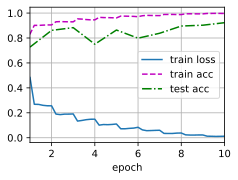

In [26]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())